# AVA Standardization Notebook
---
---

# Table of contents
1. [PRE-PROCESSING](#preprocess)
    1. [Select post-2010 data](#post2010)
    2. [Select Alaskan tundra data](#aktundra)
    3. [Access data](#dataaccess)
        1. [Auxiliary data](#auxdata)
        2. [Non-foliar fcover data](#nonfoliar)
        3. [Foliar fcover data](#foliar)
    4. [Join fcover to species checklist table](#joinchecklist)
    5. [Join fcover to leaf retention table](#joinleafretention)
    6. [Export species-PFT tables](#exporthabits)
    7. [Clean exported species-PFT tables](#cleanhabits)
2. [STANDARDIZATION](#standardization)
    1. [Standardize PFT names](#pftnames)
    2. [Sum species fcover to PFT-level](#sumfcover)
    3. [Standardize table layout](#tablelayout)
    4. [Standardize auxiliary columns](#aux)
        1. [Basic plot information](#basics)
        2. [Geographical intersections](#geo)
        3. [Duplicate coordinates](#dupes)
3. [EXPORT](#export)

# Load required packages

In [70]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pyogrio import read_dataframe
import glob
import geopandas as gpd
import sys
import os
import chardet
import regex as re
import importlib

In [71]:
# import local functions
current_dir = os.path.abspath('..')
if current_dir not in sys.path:
    sys.path.append(current_dir)
import standardize_pft_funcs as spf
importlib.reload(spf)

<module 'standardize_pft_funcs' from '/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py'>

---
---
# 1. Pre-processing <a name="preprocess"></a>
After visually inspecting each species-level fcover table for obvious errors, we saved the "cleaned" tables to a folder that we then standardized here.

In [72]:
# throughout the script this will help keep my indices matching
def normalize_to_int_str(val):
    try:
        f = float(val)
        i = int(f)
        if f == i:
            return str(i)
    except (ValueError, TypeError):
        pass
    return str(val)

In [73]:
source = 'ava'

---
## 1.3. Access data  <a name="dataaccess"></a>

### 1.3.1. Auxiliary data  <a name="auxdata"></a>

In [74]:
# read .xlsx table data stored on local machine
aux_data_path = f'input_data/ava_ancillary_data.xlsx'
aux_data = read_dataframe(aux_data_path)
aux_data = aux_data.tail(-1)

In [75]:
# set the plot visit name, plot name, and no-data values
aux_data.rename(columns={'Field releve number':'plotName'}, inplace=True)
aux_data.rename(columns={'Releve number':'plotVisit'}, inplace=True)
aux_data.index = aux_data['plotVisit'].apply(normalize_to_int_str)
na_values=[-9, -9.0, '-9', '-9.0', -1, '-1', 'None', 'NONE', None]
aux_data.replace(na_values, np.nan, inplace=True)

/tmp/ipykernel_2417623/24606776.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aux_data.replace(na_values, np.nan, inplace=True)


In [76]:
# ensure that plot visit names are unique
print(f'Total number of plot visits in aux data: {len(aux_data.index)}')
print(f'Number of unique plot visits in aux data: {len(aux_data.index.unique())}')

Total number of plot visits in aux data: 3639
Number of unique plot visits in aux data: 3639


In [77]:
# extract columns that DO NOT have "cover" in the name; this is auxiliary info
aux_cols = [col for col in aux_data.columns if 'Cover' not in col]
aux = aux_data[aux_cols].copy()

### 1.3.2. Non-foliar fcover data  <a name="nonfoliar"></a>

In [78]:
# extract columns with "cover" in the name; these contain the fcover data
cover_cols = [col for col in aux_data.columns if 'Cover' in col]
fcover = aux_data[cover_cols].copy()
fcover.drop(columns=['Cover abundance scale'], inplace=True) # not fcover

In [79]:
# extract non-vegetation fcover columns
etc = ['Cover bare soil (%)','Cover rock (%)','Cover water (%)']
non_veg = fcover[etc]
litter = fcover[['Cover litter (%)']]

# Remove the stuff we pulled out
etc.append('Cover litter (%)')
fcover.drop(columns=etc, inplace=True)

### 1.3.3. Foliar fcover data  <a name="foliar"></a>

In [80]:
# get paths to tables
species_csv_paths = sorted(glob.glob(f'input_data/ava_cover_tables/*.csv'))

In [81]:
# load tables in pandas; not all tables have known encoding
fcover_dfs = []
for path in species_csv_paths:
    with open(path, 'rb') as file:
        # dynamically detect file encoding because it is not consistent
        result = chardet.detect(file.read())
    df = pd.read_csv(path, encoding=result['encoding'], 
                     na_values=[-9, -9.0, '-9', '-9.0', 'None', 'NONE', None])
    fcover_dfs.append(df)
fcover_dfs[3].head(3)

# get fcover types from file names
cover_types = []
basenames = [os.path.basename(path) for path in species_csv_paths]
for name in basenames:
    cover_type = name.split('_')[-2]
    cover_types.append(cover_type)
print(cover_types)

['perc', 'perc', 'brbl', 'brbl', 'perc', 'perc', 'perc', 'perc', 'brbl', 'brbl', 'brbl', 'brbl', 'brbl', 'perc', 'brbl', 'hs', 'brbl', 'wv', 'perc', 'brbl', 'brbl', 'brbl', 'perc', 'perc', 'brbl', 'hs', 'wv', 'brbl']


In [82]:
# ensure plot visit names are unique
visit_names = []
num_plots = []
for df in fcover_dfs:
    nums = len(df.columns) - 3
    num_plots.append(nums)
    plot_names = df.columns[3:]
    visit_names.append(plot_names.to_list())
unique_names = [name for sublist in visit_names for name in sublist]
print(f'Total number of plot visits in fcover data: {sum(num_plots)}')
print(f'Total number of unique plot visits in fcover data: {len(set(unique_names))}')

Total number of plot visits in fcover data: 3153
Total number of unique plot visits in fcover data: 3153


In [83]:
# get unique species names from all tables
species_names = []
for df in fcover_dfs: 
    names = df.iloc[:, 0] # first col without author
    for name in names:
        if pd.notnull(name):
            species_names.append(name)
u_species_names = list(set(species_names))

print(len(u_species_names))
species_names_df = pd.DataFrame(u_species_names, columns=['datasetSpeciesName'])

1900


---
## 1.4. Join fcover to species checklist table <a name="joinchecklist"></a>

In [84]:
# load species checklist and prep for joining
checklist_path = '../etc/akveg_species_checklist.csv'
checklist_df = spf.checklist_df(checklist_path)
checklist_df.head(3)

,nameCode,checklistSpeciesName,nameStatus,nameAccepted,nameFamily,acceptedNameSource,nameLevel,speciesForm,speciesHabit
0,abroth,Abrothallus De Not.,accepted,Abrothallus De Not.,Abrothallaceae,CNALH,genus,lichen,lichen
1,abrpar,Abrothallus parmeliarum (Sommerf.) Arnold,accepted,Abrothallus parmeliarum (Sommerf.) Arnold,Abrothallaceae,CNALH,species,lichen,lichen
2,abrpey,Abrothallus peyritschii (Stein) Kotte,accepted,Abrothallus peyritschii (Stein) Kotte,Abrothallaceae,Dillman et al. 2012,species,lichen,lichen


In [85]:
species_names_df.head(3)

,datasetSpeciesName
0,Artemisia borealis
1,Triglochin maritima
2,Valeriana capitata


In [86]:
# get first 2 words (genus-species) from checklist accepted name and data species name
checklist_df['joinKey'] = checklist_df['checklistSpeciesName'].apply(spf.get_substrings)
species_names_df['joinKey'] = species_names_df['datasetSpeciesName'].apply(spf.get_substrings)
habits = spf.join_to_checklist(unique_species=species_names_df, 
                               checklist=checklist_df, 
                               u_name='datasetSpeciesName', 
                               c_unofficial_name='checklistSpeciesName', 
                               c_official_name='nameAccepted', 
                               mapping_name='joinKey',
                               habit='speciesHabit')
habits.head(3)

468 species are missing habits.
248 species still missing habits.
53 species still missing habits.
49 species still missing habits.


,datasetSpeciesName,joinKey,speciesHabit
index,,,
0,Artemisia borealis,Artemisia borealis,forb
1,Triglochin maritima,Triglochin maritima,graminoid
2,Valeriana capitata,Valeriana capitata,forb


In [87]:
species_names_df.head(3)

,datasetSpeciesName,joinKey
0,Artemisia borealis,Artemisia borealis
1,Triglochin maritima,Triglochin maritima
2,Valeriana capitata,Valeriana capitata


In [88]:
habits = species_names_df.merge(habits, how='left', left_on='datasetSpeciesName', right_on='datasetSpeciesName', suffixes=(None, '_1'))
habits = habits[['joinKey', 'datasetSpeciesName', 'speciesHabit']]

---
## 1.5. Join fcover to leaf retention table <a name="joinleafretention"></a>

In [89]:
# load leaf retention table and clean
path = '../etc/macander_leaf_retention.csv'
leaf_ret = spf.leaf_retention_df(path)
leaf_ret.head(3)

,leafRetention,retentionSpeciesName
0,deciduous,Salix
1,deciduous,Betula nana
2,deciduous,Vaccinium uliginosum


In [90]:
# add leaf retention column
habits_wleaf = spf.add_leaf_retention(habits, leaf_ret, 'leafRetention')
habits_wleaf = habits_wleaf[['datasetSpeciesName', 'joinKey', 'speciesHabit', 'leafRetention']]
habits_wleaf.head(3)

,datasetSpeciesName,joinKey,speciesHabit,leafRetention
0,Artemisia borealis,Artemisia borealis,forb,
1,Triglochin maritima,Triglochin maritima,graminoid,
2,Valeriana capitata,Valeriana capitata,forb,


In [91]:
# apply function
habits_wleaf['speciesHabit'] = habits_wleaf['speciesHabit'].apply(spf.clean_shrub_habits)
list(habits_wleaf['speciesHabit'].unique())

['forb',
 'graminoid',
 'moss',
 'shrub',
 'lichen',
 'liverwort',
 'spore-bearing',
 nan,
 'deciduous tree',
 'coniferous tree']

---
## 1.6. Export species-PFT tables <a name="exporthabits"></a>

In [92]:
# generate 3 files and dataframe of habit types
shrubs, nonshrubs, null = spf.export_habit_files(habits_wleaf,
                                                 'temp_data', 
                                                 source, 
                                                 'speciesHabit')

In [93]:
# check to make sure the files make sense
len(habits_wleaf) == (len(null) + len(nonshrubs) + len(shrubs))

True

---
## 1.7. Clean exported species-PFT tables <a name="cleanhabits"></a>
Here, we manually assessed each file. The nonshrubs were usually correct and did not have to be adjusted. Some shrubs were missing leaf retention information, so we consulted with arctic ecologists to determine it. For unknown (null) habits, we consulted arctic ecology expert, Amy Breen, to determine the issue and correct habit. After the tables were complete, all species names had a single associated habit.
- null habits
    - assign missing habits and consult ecologist when needed
- non-shrubs
    - assign leaf habit to all trees (ctrl-f to find all trees in excel)
        - coniferous tree = evergreen
        - deciduous tree  = deciduous
    - remove leaf habit if misapplied
- shrubs
    - check current leaf habits and correct if necessary
    - fill empty leaf habits
    - choose leaf habit if both evergreen & deciduous listed
    - add Stature column (dwarf shrub or not)

---
---
# 2. Standardization <a name="standardization"></a>

---
## 2.1. Standardize PFT names <a name="pftnames"></a>
deciduous shrub, evergreen shrub, graminoid, forb, litter, non-vascular (lichen, brophyte)

In [94]:
# paths to visually assessed and cleaned habit files
all_habit_types = [f'temp_data/{source}_nonshrubs_01.csv',
                   f'temp_data/{source}_shrubs_01.csv',
                   f'temp_data/{source}_nullhabit_01.csv']

# create list of habit dataframes
habit_dfs = []
for path in all_habit_types:
    habit_df = pd.read_csv(path, index_col=0)
    habit_dfs.append(habit_df)
all_habits = pd.concat(habit_dfs)

In [95]:
# show unique habit names we're working with
all_habits['speciesHabit'].unique().tolist()

['moss',
 'lichen',
 'forb',
 'graminoid',
 'liverwort',
 'spore-bearing',
 'deciduous tree',
 'coniferous tree',
 'shrub',
 'cyanobacteria',
 'algae',
 'bryophyte',
 'fungus',
 'crust']

In [96]:
# ava-specific habit name standardization function
def standardize_habit(habitrow, leafrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    new_row = []
    
    for habit, leaf in zip(habitrow, leafrow):
        
        habit = habit.lower()
        # non-shrubs
        if 'algae' in habit or 'cyanobacteria' in habit or 'crust' in habit or 'fungus' in habit:
            new_habit = 'other'
        elif habit == np.nan or 'unknown' in habit:
            new_habit = 'other'
        elif 'moss' in habit or 'liverwort' in habit:
            new_habit = 'bryophyte'
        elif 'spore-bearing' in habit:
            new_habit = 'forb'
        elif 'grass' in habit:
            new_habit = 'graminoid'
            
        # shrubs and trees
        elif 'shrub' in habit:
            new_habit = f'{leaf} shrub'
        elif 'tree' in habit:
            new_habit = f'{leaf} tree'
            
        else:
            new_habit = f'{habit}'
        new_row.append(new_habit)
    
    return new_row

In [97]:
# standardized PFT
standard_habit_col = standardize_habit(all_habits['speciesHabit'], 
                                       all_habits['leafRetention'])
all_habits['standardHabit'] = standard_habit_col
all_habits.rename(columns={'speciesHabit':'nonstandardHabit'}, inplace=True)
print(len(all_habits))
all_habits.head(3)

1900


,datasetSpeciesName,joinKey,nonstandardHabit,leafRetention,speciesStature,standardHabit
1281,Abietinella abietina,Abietinella abietina,moss,NaN,NaN,bryophyte
1582,Acarospora schleicheri,Acarospora schleicheri,lichen,NaN,NaN,lichen
1102,Achillea lanulosa,Achillea lanulosa,forb,NaN,NaN,forb


---
## 2.2. Sum species fcover to PFT-level <a name="sumfcover"></a>

In [98]:
def get_fcover_percent(dfs, cover_types, all_habits, habit_col, species_col):
    
    pft_fcover_tables = []
    species_fcover_tables = []  # New dataset with plotName, speciesNameNoAuth, percentCover columns
    
    # loop through each fcover table
    for df, cover_type in zip(dfs, cover_types):

        def normalize_column_name(name):
            try:
                f = float(name)
                i = int(f)
                if f == i:
                    return str(i)
                else:
                    return str(name)
            except (ValueError, TypeError):
                return str(name)

        # rename first three columns manually
        cols = df.columns.to_list()
        cols[0] = 'speciesNameNoAuth'
        cols[1] = 'speciesNameAccepted'
        cols[2] = 'speciesName'

        # normalize the remaining column names (likely plot IDs)
        cols[3:] = [normalize_column_name(c) for c in cols[3:]]
        df.columns = cols

        # get list of unique plot visit IDs
        plot_id_cols = df.columns.to_list()[3:]

        # get associated habit for each species
        df = df.merge(all_habits[[species_col, 'standardHabit']], left_on='speciesNameNoAuth', right_on=species_col)

        # br-bq to percentage conversion dict
        # Wood 2013. EFFECTS OF PRESCRIBED BURNING ON GRASSLAND AVIFAUNA AT RIVERLANDS MIGRATORY BIRD SANCTUARY
        bb_dict = {'r': 0.05, '+': 0.55, '1': 3.0, '2': 15.0, '3': 37.5, '4': 62.5, '5': 87.5, '-9': np.nan}
        # Westoff converstion dict
        wv_dict = {'1': 0.05, '2': 1.0, '3': 2.5, '4': 4.5, '5': 9.0, '6': 18.5, '7': 37.0, '8': 62.0, '9': 87.5}
        # Hult-Serander conversion dict
        hs_dict = {'+': 0.5, '1': 4.0, '2': 9.0, '3': 18.0, '4': 38.0, '5': 63.0, '6': 87.0}

        # convert wv codes
        if cover_type == 'wv':

            # replace westoff-van den maarel code with percentage
            df = df.astype(str)
            for col in cols[3:]:
                df.replace({col: wv_dict}, inplace=True)

        # covert br-bl codes        
        elif cover_type == 'brbl':

            # replace br-bl code with percentage
            df = df.astype(str)
            for col in cols[3:]:
                df.replace({col: bb_dict}, inplace=True)

        elif cover_type == 'hs':

            # replace hs code with percentage
            df = df.astype(str)
            for col in cols[3:]:
                df.replace({col: hs_dict}, inplace=True)

        # if already percent
        else:
            df = df.astype(str)

        # clean % data
        fcover = df.drop(columns=['speciesNameNoAuth', 'speciesNameAccepted', 'speciesName', species_col])
        fcover = fcover.loc[:, fcover.columns != habit_col].replace(' ', np.nan, regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].replace('', np.nan, regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].replace('\*', np.nan, regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].astype(float)

        # add back the standard habit column
        fcover = fcover.copy()
        fcover[habit_col] = df[habit_col] # replace codes with new fcover %

        # loop through each plot and sum fcover per pft
        pft_fcover = fcover.groupby(by=[habit_col]).sum().T
        pft_fcover.index = plot_id_cols
        pft_fcover_tables.append(pft_fcover)
        
        # Reshape the dataset to match the desired structure
        df_melted = df.melt(id_vars=['speciesNameNoAuth'], value_vars=plot_id_cols, var_name='plotVisit', value_name='percentCover')
        
        # Replace problematic values and convert percentCover to float
        df_melted['percentCover'] = pd.to_numeric(df_melted['percentCover'], errors='coerce').fillna(np.nan)
        df_melted['plotVisit'] = df_melted['plotVisit']
        
        species_fcover_tables.append(df_melted[['plotVisit', 'speciesNameNoAuth', 'percentCover']])
    
    return pft_fcover_tables, species_fcover_tables

In [99]:
# this section is working on ALL plot data
pft_fcover_dfs, species_fcover_dfs = get_fcover_percent(fcover_dfs, cover_types, all_habits, 
                                                        'standardHabit', 'datasetSpeciesName')

In [100]:
# check unique plot visits again to ensure it hasn't changed
visit_names = []
num_plots = []
for df in pft_fcover_dfs:
    nums = len(df.index)
    num_plots.append(nums)
    plot_names = df.index
    visit_names.append(plot_names.to_list())
unique_names = [name for sublist in visit_names for name in sublist]
print(f'Total number of plot visits in fcover data: {sum(num_plots)}')
print(f'Total number of unique plot visits in fcover data: {len(set(unique_names))}')

Total number of plot visits in fcover data: 3153
Total number of unique plot visits in fcover data: 3153


In [101]:
# add accepted name and standard habit to species level fcover
all_habits = all_habits[['datasetSpeciesName', 'standardHabit', 'nonstandardHabit']]
species_fcover = pd.concat(species_fcover_dfs)
species_fcover = species_fcover.rename(columns={'speciesNameNoAuth':'datasetSpeciesName'})

In [102]:
all_habits

,datasetSpeciesName,standardHabit,nonstandardHabit
1281,Abietinella abietina,bryophyte,moss
1582,Acarospora schleicheri,lichen,lichen
1102,Achillea lanulosa,forb,forb
1463,Achillea millefolium s. borealis,forb,forb
1394,Achillea millefolium subsp. borealis,forb,forb
...,...,...,...
1504,Unknown liverworts thalloid,bryophyte,liverwort
1494,Unknown liverworts thalloid,bryophyte,liverwort
1438,Unknown moss,bryophyte,moss
988,Unknown moss acrocarpous,bryophyte,moss


In [103]:
u_species_fcover = len(species_fcover['datasetSpeciesName'].unique())
u_all_habits = len(all_habits['datasetSpeciesName'].unique())
print(f'Number of unique species in species_fcover: {u_species_fcover}')
print(f'Number of unique species in all_habits: {u_all_habits}')

Number of unique species in species_fcover: 1900
Number of unique species in all_habits: 1900


In [104]:
species_fcover = species_fcover.merge(all_habits, 
                                      left_on='datasetSpeciesName', 
                                      right_on='datasetSpeciesName')
species_fcover = species_fcover[['plotVisit', 'datasetSpeciesName', 'standardHabit', 
                                 'nonstandardHabit', 'percentCover']]
species_fcover['standardHabit'] = species_fcover['standardHabit']
print(len(species_fcover['datasetSpeciesName'].unique()))
print(len(species_fcover['plotVisit'].unique()))
species_fcover.head(3)

1900
3153


,plotVisit,datasetSpeciesName,standardHabit,nonstandardHabit,percentCover
0,11686,Abietinella abietina,bryophyte,moss,0.0
1,11686,Aconitum delphinifolium [s. delphinifolium],forb,forb,0.0
2,11686,Aconogonon alaskanum,forb,forb,0.0


---
## 2.3. Standardize table layout <a name="tablelayout"></a>

In [105]:
pft_fcover = pd.concat(pft_fcover_dfs)
pft_fcover

standardHabit,bryophyte,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,lichen,other
11686,0.00,0.00,0.0,0.00,0.0,0.10,0.00,0.00,NaN
11687,0.00,2.00,0.0,0.00,0.0,2.20,10.00,0.00,NaN
11688,2.00,56.00,0.0,0.00,0.0,13.30,18.00,0.00,NaN
11689,3.10,85.00,0.0,1.00,0.0,7.30,16.00,0.00,NaN
11690,14.20,80.00,0.0,2.00,0.0,4.20,10.00,0.90,NaN
...,...,...,...,...,...,...,...,...,...
10508,66.60,33.00,NaN,0.00,NaN,18.30,2.75,5.20,NaN
10509,126.00,59.05,NaN,0.00,NaN,20.75,8.20,2.20,NaN
10510,61.50,63.15,NaN,0.00,NaN,18.30,36.55,10.95,NaN
10511,62.60,72.05,NaN,0.55,NaN,24.30,22.10,7.65,NaN


In [106]:
pft_fcover.index.is_unique

True

In [107]:
# list of necessary PFTs
pfts = ['deciduous shrub', 'deciduous tree',
        'evergreen shrub', 'evergreen tree',
        'forb', 'graminoid', 'non-vascular',
        'bryophyte', 'lichen', 'litter', 'other']

In [108]:
# add litter
print(f'Litter plot visits: {len(litter.index)}')
litter = litter.rename(columns={'Cover litter (%)': 'litter'})
pft_fcover = pft_fcover.merge(litter, how='left', left_index=True, right_index=True)
pft_fcover

Litter plot visits: 3639


,bryophyte,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,lichen,other,litter
11686,0.00,0.00,0.0,0.00,0.0,0.10,0.00,0.00,NaN,0
11687,0.00,2.00,0.0,0.00,0.0,2.20,10.00,0.00,NaN,15
11688,2.00,56.00,0.0,0.00,0.0,13.30,18.00,0.00,NaN,20
11689,3.10,85.00,0.0,1.00,0.0,7.30,16.00,0.00,NaN,50
11690,14.20,80.00,0.0,2.00,0.0,4.20,10.00,0.90,NaN,30
...,...,...,...,...,...,...,...,...,...,...
10508,66.60,33.00,NaN,0.00,NaN,18.30,2.75,5.20,NaN,NaN
10509,126.00,59.05,NaN,0.00,NaN,20.75,8.20,2.20,NaN,NaN
10510,61.50,63.15,NaN,0.00,NaN,18.30,36.55,10.95,NaN,NaN
10511,62.60,72.05,NaN,0.55,NaN,24.30,22.10,7.65,NaN,NaN


In [109]:
# create non-vascular
pft_fcover['non-vascular'] = pft_fcover[['bryophyte', 'lichen']].sum(axis=1, skipna=True)

In [110]:
# create standard columns
pft_fcover = spf.add_standard_cols(pft_fcover, pfts)
pft_fcover = pft_fcover[pfts]
pft_fcover.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,other
11686,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0,NaN
11687,2.0,0.0,0.0,0.0,2.2,10.0,0.0,0.0,0.0,15,NaN
11688,56.0,0.0,0.0,0.0,13.3,18.0,2.0,2.0,0.0,20,NaN


In [111]:
# add non-vegetation
non_veg = non_veg.rename(columns={'Cover bare soil (%)':'bare ground',
                       'Cover rock (%)':'bare ground',
                       'Cover water (%)':'water'})
non_veg = non_veg.groupby(lambda x:x, axis=1).sum()
pft_fcover = pft_fcover.merge(non_veg, left_index=True, right_index=True, how='left')
pft_fcover.head(3)

/tmp/ipykernel_2417623/2187920108.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  non_veg = non_veg.groupby(lambda x:x, axis=1).sum()


,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,other,bare ground,water
11686,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0,NaN,100.0,0.0
11687,2.0,0.0,0.0,0.0,2.2,10.0,0.0,0.0,0.0,15,NaN,70.0,0.0
11688,56.0,0.0,0.0,0.0,13.3,18.0,2.0,2.0,0.0,20,NaN,5.0,0.0


---
## 2.4. Standardize auxiliary columns <a name="aux"></a>

Plot information:
- [ ] UID
- [x] plotName
- [x] dataSource
- [x] dataSubsource
- [x] fcoverScale
- [x] surveyMethod
- [x] surveyPurpose
- [x] duplicatedCoords
- [x] duplicatedDate
- [x] surveyYear
- [x] surveyMonth
- [x] surveyDay

Geographical information:
- [x] bioclimateSubzone
- [x] adminCountry
- [x] adminUnit
- [x] fireYears
- [x] coordEpsg
- [x] georefSource
- [x] georefAccuracy
- [x] plotRadius
- [x] longitueX
- [x] latitudeY

In [112]:
# sampling methods, coverscale, data source
methods_path = '../etc/sampling_methods.csv'
methods = pd.read_csv(methods_path)

In [113]:
methods.columns

Index(['dataSource', 'dataSubsource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale',
       'surveyPurpose'],
      dtype='object')

### 2.4.1. Basic plot information <a name="basics"></a>

In [114]:
def extract_datetime(val):
    num = int(val)
    string = str(num)
    if len(string) == 8:
        year = string[0:4]
        month = string[4:6]
        day = string[6:8]
    elif len(string) == 6:
        year = string[0:4]
        month = string[4:6]
        day = np.nan
    elif len(string) == 4:
        year = string[0:4]
        month = np.nan
        day = np.nan   
    else:
        year = np.nan
        month = np.nan
        day = np.nan      
    return year, month, day

In [115]:
aux['Releve shape'].unique()

array(['irregular', 'rectangle', 'square', 'unknown (not-recorded)',
       'circular', 'linear/band-forming'], dtype=object)

In [116]:
new_aux = pd.DataFrame()

# date columns
new_aux[['surveyYear', 'surveyMonth', 'surveyDay']] = aux['Date (yyyymmdd)'].apply(extract_datetime).apply(pd.Series)

# plot size
aux['Releve area (m2)'].replace(-1, np.NaN)

# Calculate plotArea and adjust plotShape
def calculate_plot_size(row):
    try:
        area = float(row['Releve area (m2)']) if pd.notna(row['Releve area (m2)']) else np.NaN
    except ValueError:
        return row  # Return the row as-is if casting fails
    
    shape = row['Releve shape']
    
    if pd.isna(area):
        row['plotShape'] = shape if pd.notna(shape) else np.NaN
        row['plotArea'] = np.NaN  # Handle NaN area
    else:
        row['plotArea'] = area  # Always store area in plotArea
        
        # Determine the shape based on the provided value
        if shape == 'circle':
            row['plotShape'] = 'circle'
        elif shape == 'square':
            row['plotShape'] = 'square'
        else:
            row['plotShape'] = shape
    
    return row

# Apply calculations and update columns
updated_aux = aux.apply(calculate_plot_size, axis=1)

# Extract and assign the final columns
new_aux['plotArea'] = updated_aux['plotArea']
new_aux['plotShape'] = updated_aux['plotShape']

# geographical information
new_aux['latitudeY'] = aux['Latitude (decimal degrees)']
new_aux['longitudeX'] = aux['Longitude (decimal degrees)']
new_aux['georefSource'] = aux['Georeference source']
new_aux['georefAccuracy'] = aux['Georeference accuracy (m)'].astype('Float32')
new_aux['coordEPSG'] = 'EPSG:4326'

# main
new_aux['plotName'] = aux['plotName']
new_aux['dataSubsource'] = aux['Dataset'].apply(lambda name: name.replace('_', ' '))
new_aux['dataSubsource'] = new_aux['dataSubsource'].apply(lambda name: re.sub(r'\([^)]*\)', '', name))
new_aux['dataSubsource'] = new_aux['dataSubsource'].apply(lambda name: name.strip())

In [117]:
new_aux['plotShape'].unique()

array(['irregular', 'rectangle', 'square', 'unknown (not-recorded)',
       'circular', 'linear/band-forming'], dtype=object)

In [118]:
# adjust data subsource names
new_aux['dataSubsource'].replace({'Prudhoe Bay Airport ArcSEES Donald Walker':'Prudhoe Bay Airport ArcSEES Walker (pub 2016)',
                                  'Prudhoe ArcSEES road study Donald Walker':'Prudhoe ArcSEES road study Walker (pub 2015)',
                                  'Flux Tower Zona Scott Davidson':'Flux Tower Zona Davidson (pub 2016)',
                                  'Barrow DOE NGEE Victoria Sloan':'Barrow DOE NGEE Sloan (pub 2014)',
                                  'Atqasuk Vera Komarkova':'Atqasuk Villarreal (pub 2013)',
                                  'Barrow IBP Tundra Biome Pat Webber':'Barrow IBP Tundra Biome Villarreal (pub 2012)'}, inplace=True)

/tmp/ipykernel_2417623/1816956801.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_aux['dataSubsource'].replace({'Prudhoe Bay Airport ArcSEES Donald Walker':'Prudhoe Bay Airport ArcSEES Walker (pub 2016)',


In [119]:
new_aux = new_aux.reset_index(drop=False)
new_aux = new_aux.merge(methods, how='left', left_on='dataSubsource', right_on='dataSubsource')
new_aux = new_aux.set_index('plotVisit')

In [120]:
new_aux.columns

Index(['surveyYear', 'surveyMonth', 'surveyDay', 'plotArea', 'plotShape',
       'latitudeY', 'longitudeX', 'georefSource', 'georefAccuracy',
       'coordEPSG', 'plotName', 'dataSubsource', 'dataSource',
       'dataSourceHtml', 'dataSubsourceCitation', 'surveyMethod',
       'fcoverScale', 'surveyPurpose'],
      dtype='object')

### 2.4.2. Geographical intersections <a name="geo"></a>

In [121]:
# set geo info
geo_paths = ['../etc/gaul1/gaul1_asap.shp',
             '../etc/fire/InterAgencyFirePerimeterHistory_All_Years_View.shp',
             '../etc/bioclim/bioclimate_la_latlon.shp']
geo_names = ['gaul1',
             'fire',
             'bioclim']
geo_cols = [['name1', 'name0', 'geometry'],
            ['FIRE_YEAR', 'geometry'],
            ['zone', 'geometry']]

In [122]:
# create geospatial information
fcover_and_aux = pft_fcover.merge(new_aux, how='left', left_index=True, right_index=True)
fcover_and_aux.index.name = 'plotVisit'
fcover_and_aux.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,...,georefAccuracy,coordEPSG,plotName,dataSubsource,dataSource,dataSourceHtml,dataSubsourceCitation,surveyMethod,fcoverScale,surveyPurpose
plotVisit,,,,,,,,,,,,,,,,,,,,,
11686,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0,...,15.0,EPSG:4326,B_T01_02,Arctic Network Torre Jorgenson,AVA,NaN,NaN,center-staked plot along transect,percent,Survey and classify ecology and land cover in ...
11687,2.0,0.0,0.0,0.0,2.2,10.0,0.0,0.0,0.0,15,...,15.0,EPSG:4326,B_T01_03,Arctic Network Torre Jorgenson,AVA,NaN,NaN,center-staked plot along transect,percent,Survey and classify ecology and land cover in ...
11688,56.0,0.0,0.0,0.0,13.3,18.0,2.0,2.0,0.0,20,...,15.0,EPSG:4326,B_T01_04,Arctic Network Torre Jorgenson,AVA,NaN,NaN,center-staked plot along transect,percent,Survey and classify ecology and land cover in ...


In [123]:
# convert to GeoDataFrame
fcover_and_aux = gpd.GeoDataFrame(
    fcover_and_aux,
    geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'], fcover_and_aux['latitudeY']),
    crs='EPSG:4326'
).to_crs('EPSG:5936')

# add geospatial layers
fcover_and_aux = spf.add_geospatial_aux(
    fcover_and_aux,
    paths=geo_paths,
    orig_names=geo_cols
)

Finding spatial intersection for '['name1', 'name0', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:751: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged = merged.drop(columns=[col for col in merged.columns if 'geometry' in col])


Finding spatial intersection for '['FIRE_YEAR', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:751: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged = merged.drop(columns=[col for col in merged.columns if 'geometry' in col])


Finding spatial intersection for '['zone', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:751: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged = merged.drop(columns=[col for col in merged.columns if 'geometry' in col])
/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:772: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  # information; e.g., duplicate coords or dates


In [124]:
faa_li = len(fcover_and_aux.index)
faa_ui = len(fcover_and_aux.index.unique())
print(f'Number of plot visits in fcover_and_aux: {faa_li}')
print(f'Number of unique plot visits in fcover_and_aux: {faa_ui}')

Number of plot visits in fcover_and_aux: 3153
Number of unique plot visits in fcover_and_aux: 3153


In [125]:
# rename new columns
fcover_and_aux.rename(columns={'name1':'adminUnit',
                               'name0':'adminCountry',
                               'FIRE_YEAR':'fireYears',
                               'zone':'bioclimSubzone'}, inplace=True)

### 2.4.3. Duplicate coordinates <a name="dupes"></a>
This indicates that plots may have been revisited, they were very close and GPS accuracy was too low, or there is human error

In [126]:
# find duplicates
fcover_and_aux = spf.find_duplicates(fcover_and_aux, ['longitudeX', 'latitudeY'], 'duplicatedCoords')
fcover_and_aux = spf.find_duplicates(fcover_and_aux, ['surveyYear', 'surveyMonth', 'surveyDay'], 'duplicatedDate')

/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:802: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  for idx, group_id in zip(df.index, group_ids):
/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:802: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  for idx, group_id in zip(df.index, group_ids):


---
# 3. Export <a name="export"></a>

In [127]:
# clean up
pfts = {'deciduous shrub':'deciduousShrubCover',
        'evergreen shrub':'evergreenShrubCover',
        'deciduous tree':'deciduousTreeCover',
        'evergreen tree':'evergreenTreeCover',
        'forb':'forbCover',
        'graminoid':'graminoidCover',
        'non-vascular':'nonvascularSumCover',
        'bryophyte':'bryophyteCover',
        'lichen':'lichenCover',
        'litter':'litterCover',
        'bare ground':'baregroundCover',
        'water':'waterCover',
        'other':'otherCover'}

# rename columns
fcover_and_aux.rename(columns=pfts, inplace=True)
fcover_cols = list(pfts.values())

# rset cover data type
fcover_and_aux[fcover_cols] = fcover_and_aux[fcover_cols].astype(np.float32)
fcover_and_aux.index.name = 'plotVisit'

In [128]:
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'otherCover', 'baregroundCover', 'waterCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone',
       'duplicatedCoords', 'duplicatedDate'],
      dtype='object')

In [129]:
# create UID mapping to plotVisit
uid_table = pd.DataFrame({'plotVisit': pft_fcover.index})
uid_table = spf.assign_uid_column(uid_table, id_col='plotVisit', uid_col='UID')

# get UIDs from Arctic AK only
path = '../etc/tundra_alaska_latlon/tundra_alaska_wgs84.shp'
ak_tundra = gpd.read_file(path)

# clip and select Arctic AK indices
fcover_and_aux = gpd.GeoDataFrame(fcover_and_aux,
                                  geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'],
                                                              fcover_and_aux['latitudeY']),
                                                              crs='epsg:4326')
fcover_and_aux = fcover_and_aux.to_crs(ak_tundra.crs)
fcover_and_aux = fcover_and_aux.clip(ak_tundra)
valid_uids = fcover_and_aux.index
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'otherCover', 'baregroundCover', 'waterCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone',
       'duplicatedCoords', 'duplicatedDate', 'geometry'],
      dtype='object')

<Axes: >

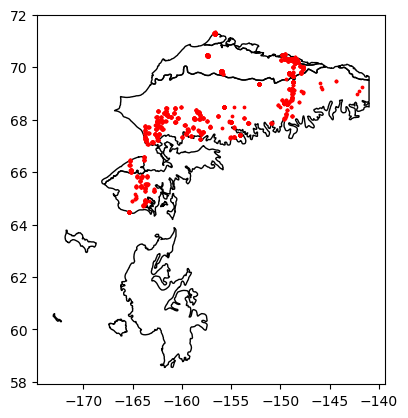

In [130]:
# plot the post-2010 alaskan tundra points
ax = ak_tundra.plot(edgecolor='black', facecolor='none')
fcover_and_aux.plot(ax=ax, color='red', markersize=3)

In [131]:
# remove geometry
fcover_and_aux['geometry'] = fcover_and_aux['geometry'].apply(lambda g: g.wkt if g is not None else None)

/tmp/ipykernel_2417623/2164478736.py:2: UserWarning: Geometry column does not contain geometry.
  fcover_and_aux['geometry'] = fcover_and_aux['geometry'].apply(lambda g: g.wkt if g is not None else None)


In [132]:
faa_li = len(fcover_and_aux.index)
faa_ui = len(fcover_and_aux.index.unique())
print(f'Number of plot visits in fcover_and_aux: {faa_li}')
print(f'Number of unique plot visits in fcover_and_aux: {faa_ui}')

Number of plot visits in fcover_and_aux: 2578
Number of unique plot visits in fcover_and_aux: 2578


In [133]:
# export species fcover
species_fcover_out = species_fcover.copy()
species_fcover_out = species_fcover_out[species_fcover_out['plotVisit'].isin(valid_uids)]
species_fcover_out = spf.replace_column_with_uid(species_fcover_out, uid_table, id_col='plotVisit', uid_col='UID', set_index=False, schema_key='species_fcover')
species_fcover_out = spf.format_column_dtypes(species_fcover_out, schema_key='species_fcover')
spf.export_dataframe(species_fcover_out, f'output_data/{source}_nonstandard_species_fcover.csv', schema_key='species_fcover', index=False)

In [134]:
# export pft fcover
covercols = [col for col in fcover_and_aux.columns if 'Cover' in col]
pft_fcover_out = fcover_and_aux[covercols]
pft_fcover_out = spf.replace_column_with_uid(pft_fcover_out.reset_index(), uid_table, id_col='plotVisit', uid_col='UID', set_index=True, schema_key='pft_fcover')
pft_fcover_out = spf.format_column_dtypes(pft_fcover_out, schema_key='pft_fcover')
spf.export_dataframe(pft_fcover_out, f'output_data/{source}_standard_pft_fcover.csv', schema_key='pft_fcover', index=True)

In [135]:
# export pft aux
auxcols = [col for col in fcover_and_aux.columns if 'Cover' not in col]
pft_aux = fcover_and_aux[auxcols]
pft_aux = spf.replace_column_with_uid(pft_aux.reset_index(), uid_table, id_col='plotVisit', uid_col='UID', set_index=True, schema_key='pft_aux')
pft_aux = spf.format_column_dtypes(pft_aux, schema_key='pft_aux')
spf.export_dataframe(pft_aux, f'output_data/{source}_plot_info.csv', schema_key='pft_aux', index=True)